In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from Model import Model
from config import get_config, get_tokenizer, get_causal_mask, load_model_from_checkpoint, visualize_attention_matrix, get_preprocessed_sequence_pd_csv, entropy_loss

c:\Users\zac's\PERSONAL\vscode projects\llm\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loss visualization

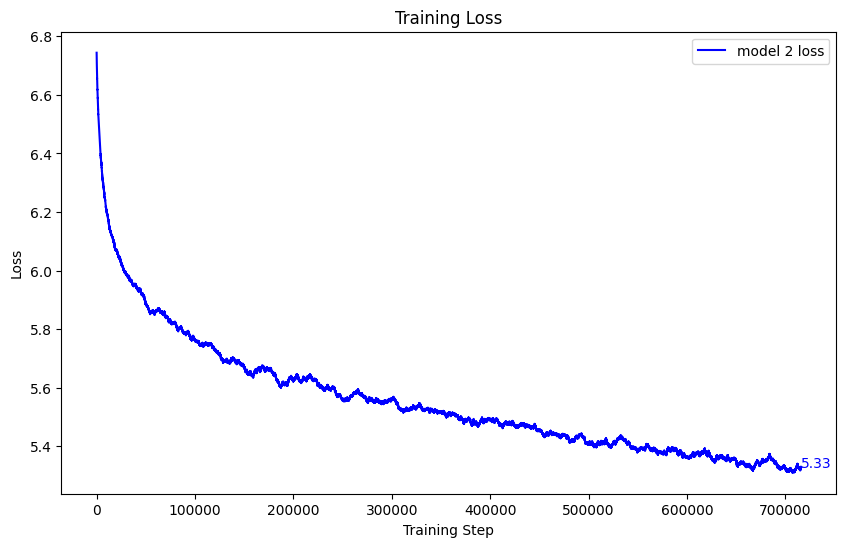

In [21]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

config = get_config()

window_size = 10000
plt.figure(figsize=(10, 6))
max_length = len(pd.read_csv(config["model_folder"] + 'losses.csv')['losses'].values.tolist())

losses = pd.read_csv(config["model_folder"] + 'losses.csv')['losses'].values.tolist()[:max_length]
smoothed_losses = moving_average(losses, window_size)
plt.plot(smoothed_losses, label='model 2 loss', color='blue')
plt.annotate(f"{smoothed_losses[-1]:.2f}", xy=(len(smoothed_losses), smoothed_losses[-1]), textcoords="data", color='blue')

plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

model inference

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

config = get_config()
tokenizer, vocab_size = get_tokenizer()

loaded_model = Model(embed_dim=config["embed_dim"],
              num_blocks=config["num_blocks"], 
              num_heads=config["num_heads"], 
              ff_dim=config["ff_dim"], 
              dropout_rate=config["dropout_rate"],
              batch_size=config["batch_size"], 
              vocab_size=vocab_size).to(device)
loaded_model, step, losses = load_model_from_checkpoint(config["model_folder"] + "model.pth", config["model_folder"] + "losses.csv", loaded_model)
loaded_model.eval()

sequence = torch.tensor(tokenizer("[START]The")['input_ids']).view(1, -1).to(device)

top_k_sample = True
while sequence[0][-1].item() != tokenizer("[END]")['input_ids'][0] and sequence.shape[-1] < 100:
    causal_mask = get_causal_mask((sequence.shape[1], sequence.shape[1]), device)
    logits, probs = loaded_model(sequence, key_padding_mask = None, causal_mask = causal_mask) # dont really need causal_mask
    if top_k_sample:
        k = 10
        top_k_probs, top_k_indices = torch.topk(logits[:, -1], k=k, dim=-1)
        predicted_token = top_k_indices[0][torch.multinomial(torch.softmax(top_k_probs, dim=-1).view(-1, k), num_samples=1).view(-1).item()]
    else:
        predicted_token = torch.argmax(probs[0][-1], dim=-1).view(1, -1)
    sequence = torch.cat((sequence, predicted_token.view(1, -1)), dim=-1)

print(''.join(map(str, [tokenizer.decode(token.item()) for token in sequence[0]])))

cuda
Loading model from checkpoint at step 735001
[START]The new Commission, together with the Council, have the option of making this new legislation.[END]


load train_df

In [4]:
train_df = pd.read_csv('datasets/wmt14_translate_de-en_train.csv',lineterminator='\n')

attention visualization

cuda
Loading model from checkpoint at step 776001


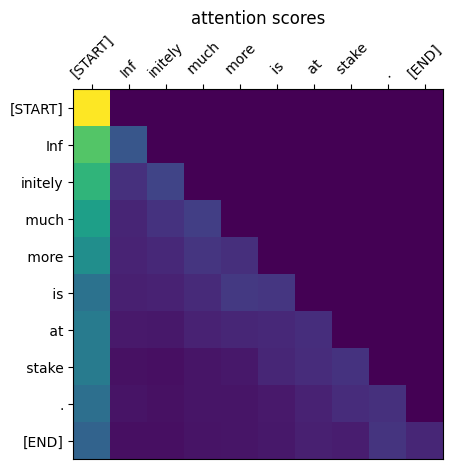

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

config = get_config()
tokenizer, vocab_size = get_tokenizer()

loaded_model = Model(embed_dim=config["embed_dim"],
              num_blocks=config["num_blocks"], 
              num_heads=config["num_heads"], 
              ff_dim=config["ff_dim"], 
              dropout_rate=config["dropout_rate"],
              batch_size=config["batch_size"], 
              vocab_size=vocab_size).to(device)
loaded_model, step, losses = load_model_from_checkpoint(config["model_folder"] + "model.pth", config["model_folder"] + "losses.csv", loaded_model)
loaded_model.eval()

# train_df = pd.read_csv('datasets/wmt14_translate_de-en_train.csv',lineterminator='\n')
import random
sequence = get_preprocessed_sequence_pd_csv(random.randint(1000000, 2000000), train_df, tokenizer, device).unsqueeze(0)

causal_mask = get_causal_mask((sequence.shape[1], sequence.shape[1]), device)
logits, probs = loaded_model(sequence, key_padding_mask = None, causal_mask = causal_mask) # dont really need causal_mask
attention_matrix = loaded_model.decoder.blocks[0].attention.last_attention
for i in range(1, 6):
    attention_matrix = torch.cat((attention_matrix, loaded_model.decoder.blocks[i].attention.last_attention))
# print(attention_matrix.shape)
visualize_attention_matrix(attention_matrix, sequence, tokenizer)